some tutorials for basic 2-layer perceptrons:

https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6

https://towardsdatascience.com/step-by-step-guide-to-building-your-own-neural-network-from-scratch-df64b1c5ab6e

https://towardsdatascience.com/how-to-build-a-deep-neural-network-without-a-framework-5d46067754d5

In [1]:
# project source code
import fann
# data structures
import pandas as pd
# calculations and algorithms
import numpy as np
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
import sklearn
from sklearn.neural_network import MLPClassifier as RefNN  # reference implementation
# visualization
import matplotlib.pyplot as plt
# sample data
import sklearn.datasets as datasets

In [2]:
def lrange(*args):
    return list(range(*args))

# construct datasets

In [3]:
NUM_FEATURES = 2
NUM_CATEGORIES = 2

def gen_data(n: int=256, noise: float=0.32, random_seed: int=1337, x_scaler=None):
    X, y = sklearn.datasets.make_moons(n_samples=n, noise=noise, random_state=random_seed)
    x_scaler = sklearn.preprocessing.StandardScaler().fit(X) if x_scaler is None else x_scaler
    X = x_scaler.transform(X)
    X = pd.DataFrame(X)
    y = pd.Series(y)
    return X, y, x_scaler
        

X_train, y_train, x_scaler = gen_data()
# for simplicity, we pretend we know ground-truth optimal hyperparameters -> don't need tuning data
# X_tune, y_tune, _ = gen_data(random_seed=1337+1, x_scaler=x_scaler)
X_test, y_test, _ = gen_data(random_seed=1337+2, x_scaler=x_scaler)

# preview
pd.concat([X_train, y_train], axis="columns", keys=["X_train", "y_train"])

X_train           y_train
            0         1       0
0   -1.720010 -0.592602       0
1   -0.263360  1.315617       0
2   -0.811233  0.593363       0
3    0.108340  1.623423       0
4   -0.252440 -0.046977       1
..        ...       ...     ...
251  0.370235 -1.117875       1
252  1.783155 -0.707722       1
253 -1.453746  0.273004       0
254  1.045813 -0.978903       1
255 -0.767574 -0.051766       1

[256 rows x 3 columns]

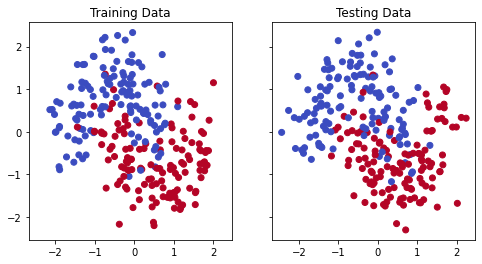

In [4]:
def plot_data(X: pd.DataFrame, y: pd.Series, title: str=None, ax=None):
    ax = plt if ax is None else ax
    # caution: in scatterplot, `x` is actually X[0] i.e. the 1st feature, `y` is X[1] i.e. 2nd feature
    ax.scatter(x=X[0], y=X[1], c=y, cmap=plt.cm.coolwarm)
    try:
        ax.set_title(title)
    except AttributeError:
        ax.title(title)
    if ax == plt:
        ax.show()


_, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
plot_data(X=X_train, y=y_train, title="Training Data", ax=axs[0])
plot_data(X=X_test, y=y_test, title="Testing Data", ax=axs[1])
plt.show()

# reference model

In [5]:
# first hidden layer has 4 neurons, second hidden layer has 3 neurons
layer_sz = (4, 3)
ref_model = RefNN(hidden_layer_sizes=layer_sz, activation="logistic",
                  solver="lbfgs", max_iter=2048, random_state=1337).fit(X=X_train, y=y_train)

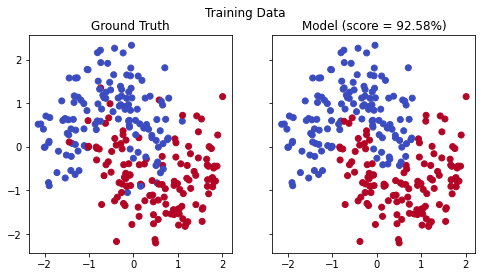

In [6]:
y_hat_train = ref_model.predict(X=X_train)
score_train = np.mean(y_hat_train == y_train)

_, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
plot_data(X=X_train, y=y_train, title="Ground Truth", ax=axs[0])
plot_data(X=X_train, y=y_hat_train, title="Model (score = {score:.2f}%)".format(score=score_train * 100), ax=axs[1])
plt.suptitle("Training Data")
plt.show()

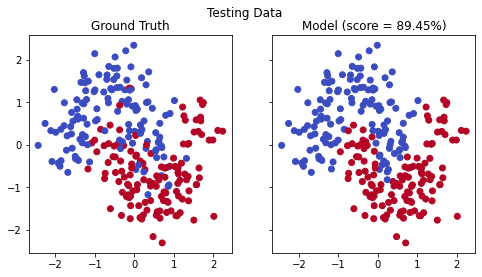

In [7]:
y_hat_test = ref_model.predict(X=X_test)
score_test = np.mean(y_hat_test == y_test)

_, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
plot_data(X=X_test, y=y_test, title="Ground Truth", ax=axs[0])
plot_data(X=X_test, y=y_hat_test, title="Model (score = {score:.2f}%)".format(score=score_test * 100), ax=axs[1])
plt.suptitle("Testing Data")
plt.show()

# homebrew model

## replicate reference model

In [9]:
# not beautiful, but this cell simply converts the reference weights to homebrew format
model = []

# hidden layers
w_bias_index = -1
# in first iteration, each neuron on input layer will get weighted & fed into each neuron on first layer
w_indices = lrange(NUM_FEATURES)
for l, sz in enumerate(layer_sz):
    neuron_indices = lrange(sz)
    
    layer = fann.NNLayer(index=neuron_indices, columns=[w_bias_index] + w_indices)
    # populate bias weights
    layer.loc[:, w_bias_index] = ref_model.intercepts_[l]
    # populate non-bias weights
    layer.loc[:, w_indices] = ref_model.coefs_[l].T
    
    assert isinstance(layer, fann.NNLayer), type(layer)
    # we know this is really just pd.DataFrame w/out MultiIndex
    assert isinstance(layer, pd.DataFrame), type(layer)
    assert not isinstance(layer.index, pd.MultiIndex), type(layer.index)
    assert not isinstance(layer.columns, pd.MultiIndex), type(layer.columns)
    model.append(layer)
    del layer

    # in next iteration, each neuron on this layer will get weighted & fed into each neuron on next layer
    w_indices = neuron_indices
    del sz
    del l
model = pd.concat(model, keys=lrange(len(layer_sz)))
assert isinstance(model, fann.NN), type(model)
# we know this is really just pd.DataFrame w/ MultiIndex
assert isinstance(model, pd.DataFrame), type(model)
assert isinstance(model.index, pd.MultiIndex), type(model.index)
assert not isinstance(model.columns, pd.MultiIndex), type(model.columns)

# output layer
if NUM_CATEGORIES != 2:
    raise ValueError("In this last step, I'm assuming binary classification!")
# using the single column index `0` (or `1`) is the part that assumes binary classification
# populate bias weight
# both output neurons should have same bias..
model.loc[pd.IndexSlice[len(layer_sz), 0], w_bias_index] = ref_model.intercepts_[-1][0]  # -1 extracts last layer
model.loc[pd.IndexSlice[len(layer_sz), 1], w_bias_index] = ref_model.intercepts_[-1][0]
# populate non-bias weights
# .. but opposite weights
model.loc[pd.IndexSlice[len(layer_sz), 0], w_indices] = -ref_model.coefs_[-1].T[0]
model.loc[pd.IndexSlice[len(layer_sz), 1], w_indices] = ref_model.coefs_[-1].T[0]

assert isinstance(model, fann.NN), type(model)
# we know this is really just pd.DataFrame w/ MultiIndex
assert isinstance(model, pd.DataFrame), type(model)
assert isinstance(model.index, pd.MultiIndex), type(model.index)
assert not isinstance(model.columns, pd.MultiIndex), type(model.columns)
model

-1          0          1          2          3
0 0   0.873385   3.944629  -0.841650        NaN        NaN
  1  22.316308 -12.993556  16.603979        NaN        NaN
  2 -25.552951  30.081200 -11.800556        NaN        NaN
  3  -1.068344   4.525354  -0.518800        NaN        NaN
1 0 -25.782396  -9.737237  25.080410 -40.164008  51.412467
  1  25.630496  18.716913 -33.278286  50.685572  -9.136564
  2  15.599658   7.432398  -6.167783  11.372810  -1.191241
2 0   3.980336  74.614951 -54.646973 -16.600309        NaN
  1   3.980336 -74.614951  54.646973  16.600309        NaN

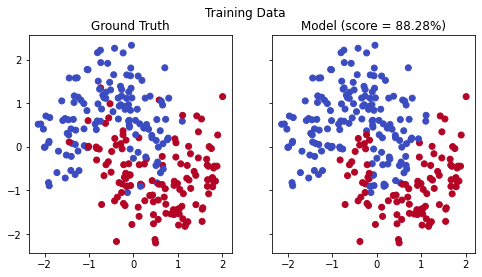

In [55]:
# TODO(sparshsah): in principle, this should match exactly the reference implementation
y_hat_train = fann.predict(X=X_train, nn=model)
score_train = np.mean(y_hat_train == y_train)

_, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
plot_data(X=X_train, y=y_train, title="Ground Truth", ax=axs[0])
plot_data(X=X_train, y=y_hat_train, title="Model (score = {score:.2f}%)".format(score=score_train * 100), ax=axs[1])
plt.suptitle("Training Data")
plt.show()

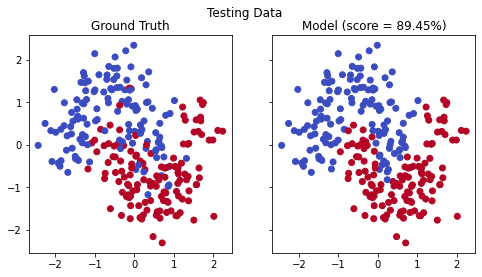

In [56]:
y_hat_train = fann.predict(X=X_test, nn=model)
score_test = np.mean(y_hat_test == y_test)

_, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
plot_data(X=X_test, y=y_test, title="Ground Truth", ax=axs[0])
plot_data(X=X_test, y=y_hat_test, title="Model (score = {score:.2f}%)".format(score=score_test * 100), ax=axs[1])
plt.suptitle("Testing Data")
plt.show()

## train our own

In [54]:
from importlib import reload
reload(fann)
del reload